In [122]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import division
from geopy.distance import vincenty
import pandas as pd
from math import sin, cos, acos, radians
from pandas import DataFrame, Series
%matplotlib inline
%load_ext Cython

# グループ5： 九州における鳥インフルエンザ感染拡大のシミュレーション

## 練習として簡単なSIRを動かしてみる

## モデル式
$$
\frac{dS}{dt} = -\lambda S * I \\ 
\frac{dI}{dt} = \lambda S * I - \gamma I \\
R = N - (S + I) \\
$$

In [136]:
def f(y, a):
    return a * y
def rk(x,y,h,func, *static_args):
    y0d=func(y, *static_args)
    y1=y+y0d*h/2.0
    y1d=func(y1, *static_args)
    y2=y+y1d*h/2.0
    y2d=func(y2, *static_args)
    y3=y+y2d*h/2.0
    y3d=func(y3, *static_args)
    return y+(y0d+2.0*y1d+2.0*y2d+y3d)*h/6.0

In [145]:
y=1.0
x=0.0
h=0.01
m= 1000
a = 1
xx=m*[0.0]
y2=m*[0.0]
for i in range(m):
    y=rk(x,y,h,f, a)
    x=x+h
    xx[i]=x
    y2[i]=y

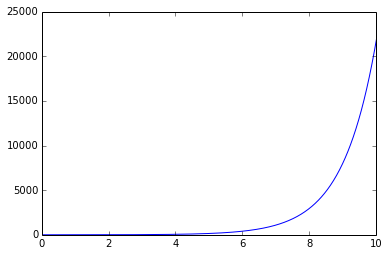

In [146]:
plt.plot(xx, y2)

In [162]:
def dS(S, I, beta):
    return -beta * I  * S
def dI(I, S, beta, gamma):
    return beta * I  * S - gamma * I

def rk(x,y,h,func, *static_args):
    y0d=func(y, *static_args)
    y1=y+y0d*h/2.0
    y1d=func(y1, *static_args)
    y2=y+y1d*h/2.0
    y2d=func(y2, *static_args)
    y3=y+y2d*h/2.0
    y3d=func(y3, *static_args)
    return y+(y0d+2.0*y1d+2.0*y2d+y3d)*h/6.0

In [191]:
I = 1
S = 99
beta = 2
gamma = 8
dt = 1
I=1
S=100
x=0.0
h=0.001
m= 100
xx=m*[0.0]
Ss=m*[0.0]
Is=m*[0.0]
for i in range(m):
    # 微分方程式に従って値を更新
    S=rk(x,S,h,dS, I, beta)
    I=rk(x,I,h,dI, S, beta, gamma)
    print S, I
    Ss[i]=S
    Is[i]=I
    # 時間を更新
    x=x+h
    xx[i]=x


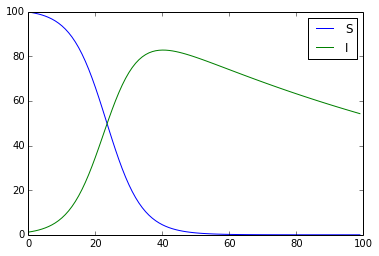

In [193]:
plt.plot(Ss, label='S')
plt.plot(Is, label='I')
plt.legend()

In [200]:
def dS(S, I, beta):
    return -beta * I  * S
def dI(I, S, beta, gamma):
    return beta * I  * S - gamma * I

def rk(x,y,h,func, *static_args):
    '''
    ルンゲクッタ法を実行して，微分方程式から次の実行ステップの微分方程式
    の行き先を返す関数
    y: その地点での微分方程式の解の値
    h: 刻み幅(dt)
    func: 解く微分方程式
    *static_args: 微分方程式に代入する他の変数
    '''
    y0d=func(y, *static_args)
    y1=y+y0d*h/2.0
    y1d=func(y1, *static_args)
    y2=y+y1d*h/2.0
    y2d=func(y2, *static_args)
    y3=y+y2d*h/2.0
    y3d=func(y3, *static_args)
    return y+(y0d+2.0*y1d+2.0*y2d+y3d)*h/6.0

In [212]:
# パラメタ
beta = 2
gamma = 8
# 初期値
N = 5000
# 時間, 刻み幅
time = 0.0
# 時間刻み
dt = 1
h = 0.001
duration = 1000
times = np.zeros(duration)
Ss = np.zeros(duration)
Is = np.zeros(duration)
Rs = np.zeros(duration)
for i in range(duration):
    # 微分方程式に従って値を更新
    S=rk(time,S,h,dS, I, beta)
    I=rk(time,I,h,dI, S, beta, gamma)
    Ss[i]=S
    Is[i]=I
    Rs[i]=N-(I+S)
    # 時間を更新
    time=time+dt
    times[i]=time

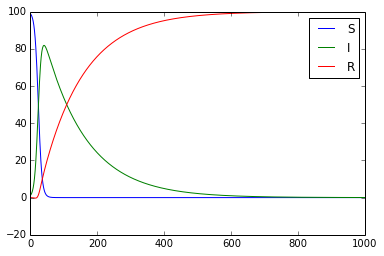

In [213]:
plt.plot(Ss, label='S')
plt.plot(Is, label='I')
plt.plot(Rs, label='R')
plt.legend()

In [214]:
# Ss, Is, Rsをマルチにする．各行がそれぞれの地点に対応し，各列が同時刻のデータに対応する

In [226]:
a = np.arange(5)

In [230]:
a[3]

1

In [7]:
def dS_multi(S, I, beta, node, St, It, C):
    '''
        St, It: vector
        node: 更新するノード
    '''
    # 和のファクタの計算
    other_nodes = np.ones_like(It, dtype=bool) * np.True_
    other_nodes[node] = np.False_
    return -beta * I  * S - beta * np.sum(S * It[other_nodes] * C[other_nodes])

def dI_multi(I, S, beta, gamma, node, St, It, C):
    '''
        St, It: vector
        node: 更新するノード
    '''
    # 和のファクタの計算
    other_nodes = np.ones_like(It, dtype=bool) * np.True_
    other_nodes[node] = np.False_
    return beta * I  * S + beta * np.sum(S * It[other_nodes]* C[other_nodes]) - gamma * I 

def rk(y,h,func, *static_args):
    '''
    ルンゲクッタ法を実行して，微分方程式から次の実行ステップの微分方程式
    の行き先を返す関数
    y: その地点での微分方程式の解の値
    h: 刻み幅(dt)
    func: 解く微分方程式
    *static_args: 微分方程式に代入する他の変数
    '''
    y0d=func(y, *static_args)
    if np.abs(y0d) < 1e-8:
        y0d = 0
    y1=y+y0d*h/2.0
    y1d=func(y1, *static_args)
    if np.abs(y1d) < 1e-8:
        y1d = 0
    y2=y+y1d*h/2.0
    y2d=func(y2, *static_args)
    if np.abs(y2d) < 1e-8:
        y2d = 0
    y3=y+y2d*h/2.0
    y3d=func(y3, *static_args)
    if np.abs(y3d) < 1e-8:
        y3d = 0
    return np.abs(y+(y0d+2.0*y1d+2.0*y2d+y3d)*h/6.0)

In [22]:
# パラメタ
#beta = 2/5 
#gamma = 1/6
beta = 0.4
#gamma = 0.6  * 0.1
gamma = 0.166666667
# 初期時間
time = 0.0
# 時間刻み
dt = 1e-4
# シミュレーション日数
duration = int(30e+4)
times = np.zeros(duration)
num_node = 2
Ns = np.zeros(num_node)
Ss = np.zeros((num_node, duration))
Is = np.zeros((num_node, duration))
Rs = np.zeros((num_node, duration))
# 暫定的なCt, 実際はここらへんで計算しておく
Ct = np.ones((num_node, num_node)) * 0
# 初期値
Ns[:] = 5000
Ss[:, 0] = 4900
Is[:, 0] = 100
for j in range(1, duration):
    # 微分方程式に従って値を更新
    for i in range(num_node):        
        Ss[i, j] = rk(Ss[i, j-1], dt, dS_multi, Is[i, j-1], beta, i, Ss[:, j], Is[:, j], Ct[i, :])
        Is[i, j] = rk(Is[i, j-1], dt, dI_multi, Ss[i, j-1], beta, gamma, i, Ss[:, j], Is[:, j], Ct[i, :])
        Rs[i, j] = Ns[i] - (Is[i, j] + Ss[i, j])
        # 時間を更新
    times[j] = times[j-1] + dt

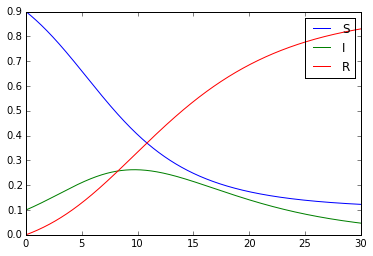

In [23]:
plt.plot(times, Ss[0, :], label='S')
plt.plot(times, Is[0, :], label='I')
plt.plot(times, Rs[0, :], label='R')
plt.legend()

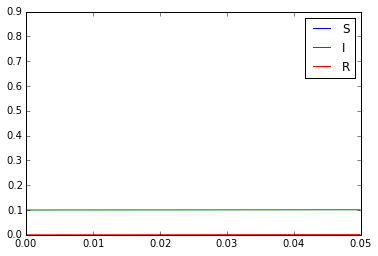

In [24]:
end = 500
plt.plot(times[0:end], Ss[0, 0:end], label='S')
plt.plot(times[0:end], Is[0, 0:end], label='I')
plt.plot(times[0:end], Rs[0, 0:end], label='R')
plt.legend()

In [28]:
geo_data = pd.read_excel('../data/geo_data.xls')

In [29]:
geo_data

,MESH_ID,population per grid,bird house per grid,x,y
0,483022,212.388873,0.048285,130.310207,32.211750
1,493240,227.219123,0.027662,132.060026,33.045029
2,493220,238.449943,0.050156,132.060039,32.878388
3,493250,254.670676,0.000000,132.060030,33.128355
4,463062,316.392284,0.063887,130.310242,31.211860
5,493003,317.552718,0.220971,130.435180,32.711699
6,473113,343.231812,0.102835,131.435130,31.461853
7,463046,419.374128,0.665755,130.810196,31.045221
8,493176,420.967305,0.015826,131.810042,33.294996
9,503030,495.328189,0.093982,130.060188,33.628258


In [39]:
# まずざっとプロットしてみる．x, yのみ

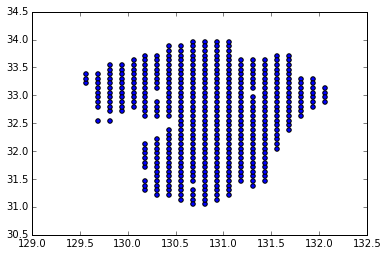

In [30]:
plt.scatter(geo_data['x'], geo_data['y'])

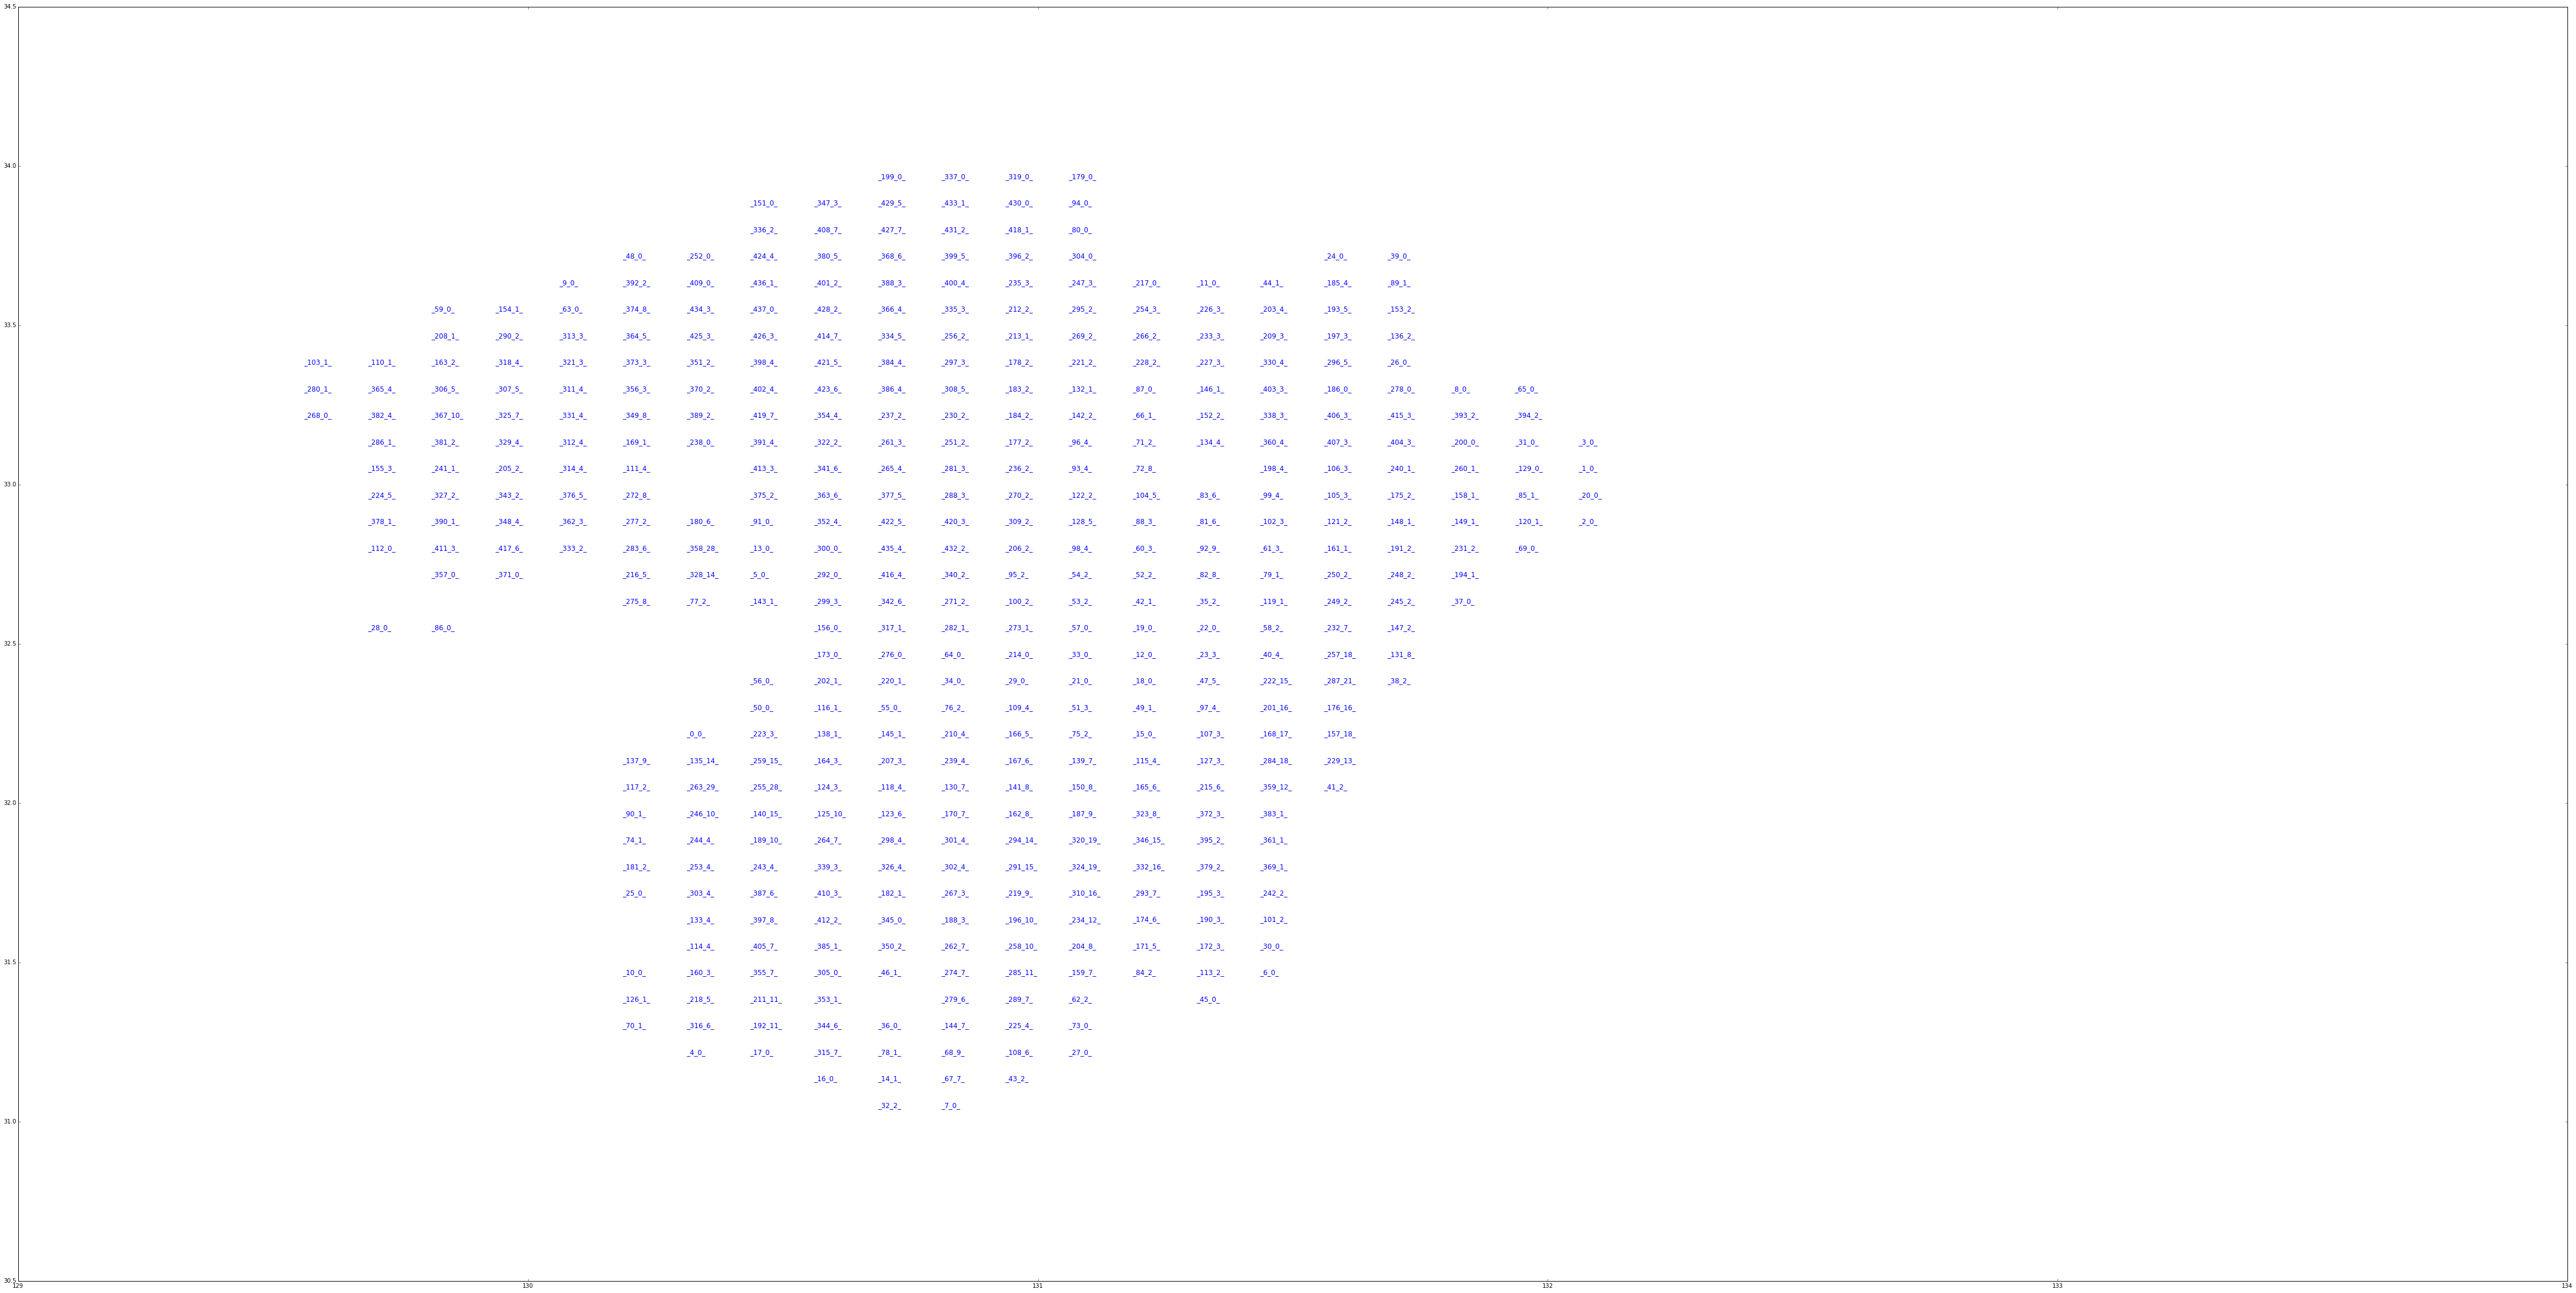

In [185]:
plt.figure(figsize=(80, 40))
plt.xlim((129, 134))
plt.ylim((30.5, 34.5))
for row in range(geo_data.shape[0]):
    plt.annotate("_"+str(int(row))+"_"+str(int(geo_data['bird house per grid'][row]))+"_",
                 xy=(geo_data['x'][row], geo_data['y'][row]), fontsize=12, color='b')
    

In [82]:
# http://qiita.com/s-wakaba/items/e12f2a575b6885579df7
earth_rad = 6378.137
def latlng_to_xyz(lat, lng):
    rlat, rlng = radians(lat), radians(lng)
    coslat = cos(rlat)
    return coslat*cos(rlng), coslat*sin(rlng), sin(rlat)

def dist_on_sphere(pos0, pos1, radious=earth_rad):
    xyz0, xyz1 = latlng_to_xyz(*pos0), latlng_to_xyz(*pos1)
    return acos(sum(x * y for x, y in zip(xyz0, xyz1)))*radious

In [88]:
distance_distribution = np.zeros((geo_data.shape[0], geo_data.shape[0]))
for row1 in range(geo_data.shape[0]):
    for row2 in range(row1):
        distance_distribution[row1][row2] = dist_on_sphere(
                (geo_data['x'][row1], geo_data['y'][row1]),
                (geo_data['x'][row2], geo_data['y'][row2]))


In [90]:
distance_distribution += distance_distribution.T - np.diag(np.diag(distance_distribution))

<matplotlib.colorbar.Colorbar instance at 0x7fbc89404170>

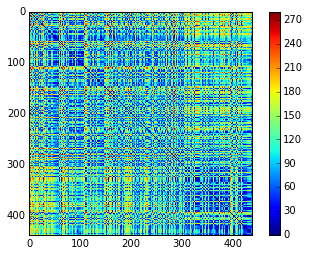

In [92]:
plt.imshow(distance_distribution, interpolation='nearest')
plt.colorbar()

$$
c_{i, j}=\exp{(-d_{i, j}/100)}
$$
での減衰を考える

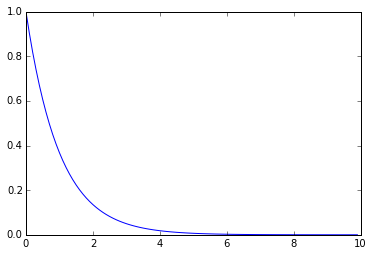

In [36]:
x = np.arange(0, 10, 0.1)
plt.plot(x, np.exp(-x))

In [98]:
attenuation_matrix = np.exp(-distance_distribution/100)

<matplotlib.colorbar.Colorbar instance at 0x7fbc86960ab8>

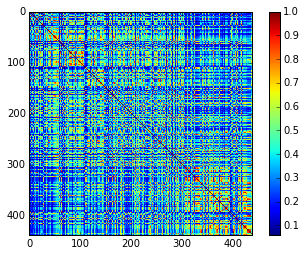

In [99]:
plt.imshow(attenuation_matrix, interpolation='nearest')
plt.colorbar()

In [100]:
attenuation_matrix

array([[ 1.        ,  0.12984947,  0.13422455, ...,  0.55248865,
         0.35670434,  0.37857128],
       [ 0.12984947,  1.        ,  0.88314058, ...,  0.21406027,
         0.15586969,  0.15792859],
       [ 0.13422455,  0.88314058,  1.        , ...,  0.21616157,
         0.15097284,  0.15354375],
       ..., 
       [ 0.55248865,  0.21406027,  0.21616157, ...,  1.        ,
         0.51465879,  0.54334589],
       [ 0.35670434,  0.15586969,  0.15097284, ...,  0.51465879,
         1.        ,  0.94161347],
       [ 0.37857128,  0.15792859,  0.15354375, ...,  0.54334589,
         0.94161347,  1.        ]])

# ここまでで，Cの値は得られた，次，各ノードのNの値を求める

In [113]:
Ns = np.array(geo_data['population per grid'])

In [117]:
Ns.shape

(438,)

In [129]:
# パラメタ
#beta = 2/5 
#gamma = 1/6
beta = 0.4
#gamma = 0.6  * 0.1
gamma = 0.166666667
# 初期時間
time = 0.0
# 時間刻み
dt = 1e-6
# シミュレーション日数
duration = int(1e+6)
times = np.zeros(duration)
num_node = geo_data.shape[0]
Ns = geo_data['population per grid']
Ss = np.zeros((num_node, duration))
Is = np.zeros((num_node, duration))
Rs = np.zeros((num_node, duration))
# 暫定的なCt, 実際はここらへんで計算しておく
Ct = np.ones((num_node, num_node)) * 0
# 初期値
Ss[:, 0] = Ns
Is[:, 0] = 0
# 初期感染
Is[437, :] = 1

for j in range(1, duration):
    # 微分方程式に従って値を更新
    for i in [437, 20]:        
        Ss[i, j] = rk(Ss[i, j-1], dt, dS_multi, Is[i, j-1], beta, i, Ss[:, j], Is[:, j], attenuation_matrix[i, :])
        Is[i, j] = rk(Is[i, j-1], dt, dI_multi, Ss[i, j-1], beta, gamma, i, Ss[:, j], Is[:, j], attenuation_matrix[i, :])
        Rs[i, j] = Ns[i] - (Is[i, j] + Ss[i, j])
        # 時間を更新
    times[j] = times[j-1] + dt

KeyboardInterrupt: 

In [130]:
Ss[437, :]

array([ 712282.39502759,  712282.11011468,  712281.7335272 , ...,
             0.        ,       0.        ,       0.        ])

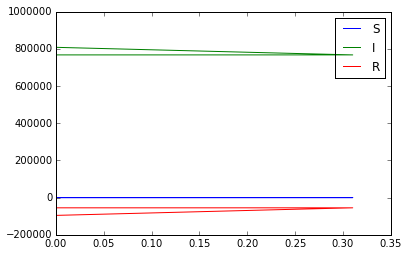

In [132]:
plt.plot(times, Ss[437, :], label='S')
plt.plot(times, Is[437, :], label='I')
plt.plot(times, Rs[437, :], label='R')
plt.legend()

In [161]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
import sys
@cython.boundscheck(False)
def dS_multi(float S, float I, float beta, int node,
             np.ndarray[np.float32_t, ndim=1] St,
             np.ndarray[np.float32_t, ndim=1] It,
             np.ndarray[np.float32_t, ndim=1] C):
    '''
        St, It: vector
        node: 更新するノード
    '''
    # 和のファクタの計算
    cdef int other_node
    cdef float summation = 0
    for other_node in range(len(St)):
        if other_node != node:
            summation += S * It[other_node] * C[other_node]
    return -beta * I  * S - beta * summation

def dI_multi(float I, float S, float beta, float gamma, int node,
             np.ndarray[np.float32_t, ndim=1] St,
             np.ndarray[np.float32_t, ndim=1] It,
             np.ndarray[np.float32_t, ndim=1] C):
    '''
        St, It: vector
        node: 更新するノード
    '''
    # 和のファクタの計算
    cdef int other_node
    cdef float summation = 0
    for other_node in range(len(St)):
        if other_node != node:
            summation += S * It[other_node] * C[other_node]
    return beta * I  * S + beta * summation - gamma * I 

def rk_dS(float S,float h, float I, float beta, int node,
             np.ndarray[np.float32_t, ndim=1] St,
             np.ndarray[np.float32_t, ndim=1] It,
             np.ndarray[np.float32_t, ndim=1] C):
    '''
    ルンゲクッタ法を実行して，微分方程式から次の実行ステップの微分方程式
    の行き先を返す関数
    y: その地点での微分方程式の解の値
    h: 刻み幅(dt)
    func: 解く微分方程式
    *static_args: 微分方程式に代入する他の変数
    '''
    
    cdef float y0d = dS_multi(S, I, beta, node, St, It, C)
    if abs(y0d) < 1e-8:
        y0d = 0
    cdef float y1=S+y0d*h/2.0
    cdef float y1d = dS_multi(y1, I, beta, node, St, It, C)
    if abs(y1d) < 1e-8:
        y1d = 0
    cdef float y2=S+y1d*h/2.0
    cdef float y2d = dS_multi(y2, I, beta, node, St, It, C)
    if abs(y2d) < 1e-8:
        y2d = 0
    cdef float y3=S+y2d*h/2.0
    cdef float y3d = dS_multi(y3, I, beta, node, St, It, C)
    if abs(y3d) < 1e-8:
        y3d = 0
    cdef float next_S = S+(y0d+2.0*y1d+2.0*y2d+y3d)*h/6.0
    if abs(next_S) < 1e-8:
        return 0
    return next_S



def rk_dI(float I,float h, float S, float beta, float gamma, int node,
             np.ndarray[np.float32_t, ndim=1] St,
             np.ndarray[np.float32_t, ndim=1] It,
             np.ndarray[np.float32_t, ndim=1] C):
    '''
    ルンゲクッタ法を実行して，微分方程式から次の実行ステップの微分方程式
    の行き先を返す関数
    y: その地点での微分方程式の解の値
    h: 刻み幅(dt)
    func: 解く微分方程式
    *static_args: 微分方程式に代入する他の変数
    '''
    
    cdef float y0d = dI_multi(I, S, beta, gamma, node, St, It, C)
    if abs(y0d) < 1e-8:
        y0d = 0
    cdef float y1=I+y0d*h/2.0
    cdef float y1d = dI_multi(y1, S, beta, gamma, node, St, It, C)
    if abs(y1d) < 1e-8:
        y1d = 0
    cdef float y2=I+y1d*h/2.0
    cdef float y2d = dI_multi(y2, S, beta, gamma, node, St, It, C)
    if abs(y2d) < 1e-8:
        y2d = 0
    cdef float y3=I+y2d*h/2.0
    cdef float y3d = dI_multi(y3, S, beta, gamma, node, St, It, C)
    if abs(y3d) < 1e-8:
        y3d = 0
    cdef float next_I = I+(y0d+2.0*y1d+2.0*y2d+y3d)*h/6.0
    if abs(next_I) < 1e-8:
        return 0
    return next_I

def solve_ODE_SIR(np.ndarray[np.float32_t, ndim=2] Ss,
                  np.ndarray[np.float32_t, ndim=2] Is, 
                  np.ndarray[np.float32_t, ndim=2] Rs,
                  np.ndarray[np.float32_t, ndim=1] Ns,
                  np.ndarray[np.float32_t, ndim=2] Ct,
                  int duration, float dt, float beta, float gamma):
    cdef int i, j
    cdef int num_node = Ss.shape[0]
    cdef np.ndarray[np.float32_t, ndim=1] times = np.zeros(duration, dtype=np.float32)
    for j in range(1, duration):
        # 微分方程式に従って値を更新
        for i in range(num_node):        
            Ss[i, j] = rk_dS(Ss[i, j-1], dt, Is[i, j-1], beta, i,Ss[:, j], Is[:, j], Ct[i, :])
            Is[i, j] = rk_dI(Is[i, j-1], dt, Ss[i, j-1], beta, gamma, i, Ss[:, j], Is[:, j], Ct[i, :])
            Rs[i, j] = Ns[i] - (Is[i, j] + Ss[i, j])
            # 時間を更新
        times[j] = times[j-1] + dt
    return Ss, Is, Rs, times

In [164]:
beta = float(0.4)
#gamma = 0.6  * 0.1
gamma = float(0.166666667)
# 初期時間
time = float(0.0)
# 時間刻み
dt = float(1e-5)
# シミュレーション日数
duration = int(30e+5)
num_node = int(2)
Ns = np.zeros(num_node, dtype=np.float32)
Ss = np.zeros((num_node, duration), dtype=np.float32)
Is = np.zeros((num_node, duration), dtype=np.float32)
Rs = np.zeros((num_node, duration), dtype=np.float32)
# 暫定的なCt, 実際はここらへんで計算しておく
Ct = np.ones((num_node, num_node), dtype=np.float32) * 0
# 初期値
Ns[:] = 5000
Ss[:, 0] = 4900
Is[:, 0] = 100
Ss, Is, Rs, times = solve_ODE_SIR(Ss, Is, Rs, Ns, Ct, duration, dt, beta, gamma)

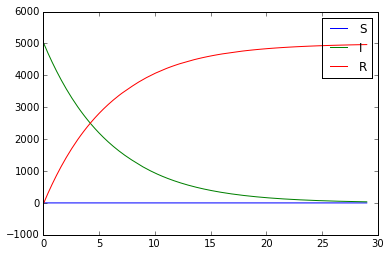

In [165]:
plt.plot(times, Ss[0, :], label='S')
plt.plot(times, Is[0, :], label='I')
plt.plot(times, Rs[0, :], label='R')
plt.legend()

In [ ]:
plt.plot(times, Ss[0, :], label='S')
plt.plot(times, Is[0, :], label='I')
plt.plot(times, Rs[0, :], label='R')
plt.legend()